In [1]:
# Enable further imports

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import matplotlib.pyplot as plt
import torch

from torch.nn import ModuleList, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import classification_report

from tqdm.notebook import tqdm

from data import BinaryColoredMNIST

from models import MLPEncoder, ConvEncoder, Classifier, Adversary

from train import Trainer

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


### Data Modification

In [4]:
data_dir = os.path.join(project_root, "data/mnist_data")
train_set = BinaryColoredMNIST(root=data_dir, p_even_red=0.3, p_even_blue=0.8, prob_a=0.5, device=device)

In [5]:
train_set, val_set = random_split(train_set, [0.8, 0.2])

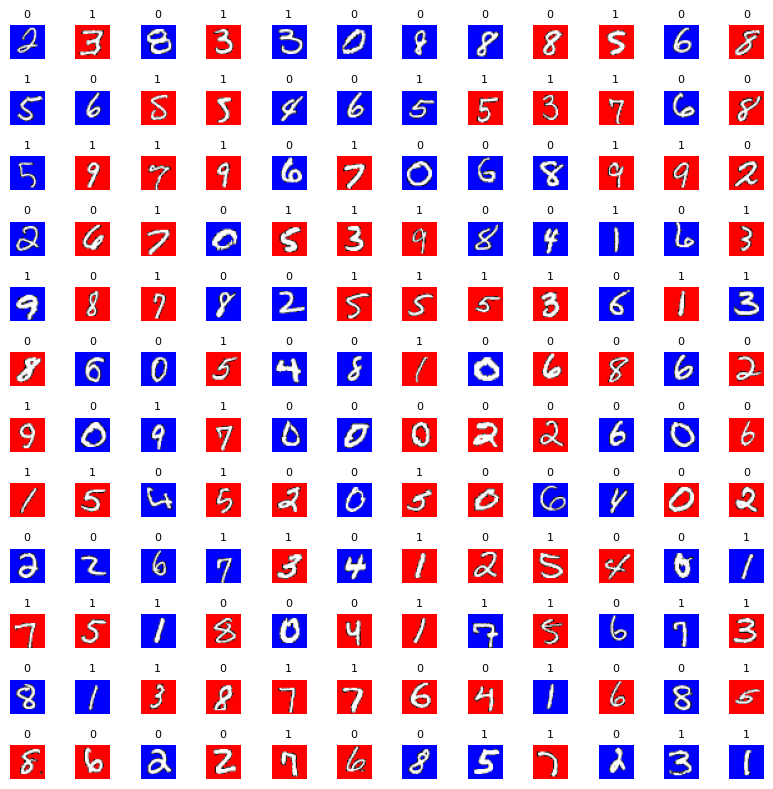

In [6]:
data = train_set[:144]

plt.figure(figsize=(8, 8))

for i, (img, a, label) in enumerate(zip(*data)):
    plt.subplot(12, 12, i + 1)
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.title(str(label.item()), fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [7]:
# Setup for DP
C = 2
K = 2
latent_dim = 10

batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

encoder = MLPEncoder(latent_dim)
classifier = Classifier(latent_dim)
adversary = Adversary(latent_dim)

trainer = Trainer(train_loader, val_loader, encoder, classifier, adversary, C, K, device)

In [12]:
gamma = 1

learning_rate = 1e-2

criterion_class = CrossEntropyLoss()
optimizer_enc_class = Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)
optimizer_adv = Adam(adversary.parameters(), lr=learning_rate)

losses_enc, losses_adv = trainer.train(criterion_class, optimizer_enc_class, optimizer_adv, gamma, verbose=True)

  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 1 (encoder+classifier loss: -0.6676, adversary loss: 1.0314)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 2 (encoder+classifier loss: -0.8205, adversary loss: 1.0002)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 3 (encoder+classifier loss: -0.8614, adversary loss: 1.0000)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 4 (encoder+classifier loss: -0.8828, adversary loss: 1.0000)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 5 (encoder+classifier loss: -0.8906, adversary loss: 1.0000)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 6 (encoder+classifier loss: -0.9031, adversary loss: 1.0000)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 7 (encoder+classifier loss: -0.9096, adversary loss: 1.0000)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 8 (encoder+classifier loss: -0.9175, adversary loss: 1.0000)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 9 (encoder+classifier loss: -0.9237, adversary loss: 1.0000)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 10 (encoder+classifier loss: -0.9308, adversary loss: 1.0000)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 11 (encoder+classifier loss: -0.9290, adversary loss: 1.0000)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 12 (encoder+classifier loss: -0.9289, adversary loss: 1.0000)


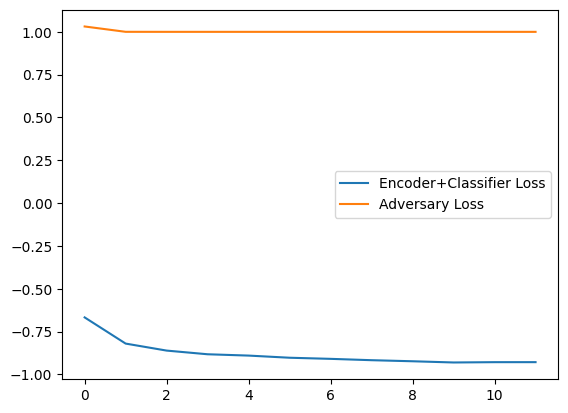

In [13]:
plt.plot(losses_enc, label="Encoder+Classifier Loss")
plt.plot(losses_adv, label="Adversary Loss")

plt.legend()
plt.show()

In [14]:
test_set = BinaryColoredMNIST(root=data_dir, p_even_red=0.5, p_even_blue=0.5, prob_a=0.5, train=False, device=device)
x, a_true, y_true = test_set.dataset

z = encoder(x)

a_pred = trainer.pred_adversary(z, y_true).argmax(dim=1)
y_pred = classifier(z).argmax(dim=1)

# test_loader = tqdm(
#     DataLoader(test_set, batch_size=batch_size, shuffle=True),
#     unit="batch",
#     leave=False
# )

# y_pred = []
# y_true = []
# a_pred = []
# a_true = []

# for (x, a, y) in test_loader:
#     x = x.to(device)
#     a = a.to(device)
#     y = y.to(device)

#     z = encoder(x)
    
#     y_preds = classifier(z).argmax(dim=1)
#     a_preds = trainer.pred_adversary(z, y).argmax(dim=1)
    
#     a_pred.append(a_preds.cpu())
#     y_pred.append(y_preds.cpu())
    
#     a_true.append(a.cpu())
#     y_true.append(y.cpu())

# a_pred = torch.cat(a_pred, dim=0).numpy()
# a_true = torch.cat(a_true, dim=0).numpy()

# y_pred = torch.cat(y_pred, dim=0).numpy()
# y_true = torch.cat(y_true, dim=0).numpy()

In [15]:
a_pred = a_pred.cpu().numpy()
a_true = a_true.cpu().numpy()
y_pred = y_pred.cpu().numpy()
y_true = y_true.cpu().numpy()

print("Classifier:")
print(classification_report(y_true, y_pred, zero_division=0))

print()
print()

print("Adversary:")
print(classification_report(a_true, a_pred, zero_division=0))

Classifier:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4926
           1       0.97      0.95      0.96      5074

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



Adversary:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      4999
           1       0.00      0.00      0.00      5001

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000

